In [79]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from benchmark.bbobbenchmarks import F1, F2, F3, F4, F5, F16 # only noiseless functions

from bayes_optim import BO
from bayes_optim.search_space import RealSpace
from bayes_optim.surrogate import GaussianProcess, trend

In [100]:
dim = 2
lb, ub = -5, 5

space = RealSpace([lb, ub]) * dim

mean = trend.constant_trend(dim, beta=None)
thetaL = 1e-10 * (ub - lb) * np.ones(dim)
thetaU = 10 * (ub - lb) * np.ones(dim)
theta0 = np.random.rand(dim) * (thetaU - thetaL) + thetaL

doe_size = 5
max_FEs = 10
verbose = False

In [113]:
def plot(points, colors, ax=plt, outline=False):
    transposed = np.transpose(points)
    if outline:
        ax.scatter(transposed[0], transposed[1], color="none", edgecolor=colors)
    else:
        ax.scatter(transposed[0], transposed[1], c=colors)
        
def plot_one_function(func, samples, values, results):
    fig, axs = plt.subplots(1, len(results))
    fig.suptitle("Objective function: " + str(func.__class__))
    for (result, ax) in zip(results, axs):
        plot(samples, values, ax=ax, outline=False)
        plot([samples[values.argmin()], result["found_x"]], ["green", "red"], ax=ax, outline=True)
        if result["initial_points"] is not None:
            plot(result["initial_points"], ["red"] * result["initial_points"].shape[0], ax=ax, outline=False)
    plt.show()

In [114]:
def test(samples, values, found_x, found_value):
    min_x = samples[values.argmin()]
    transposed = np.transpose(samples)
    min_sampled, max_sampled = values.min(), values.max()
    return {"err": found_value - min_sampled, \
            "normalized": (found_value - min_sampled) / (max_sampled - min_sampled),
            "min": min_sampled, 
            "max": max_sampled, 
            "found_value": found_value, 
            "found_x": found_x}

In [115]:
def sub_experiment(obj_function, initial_points, test_samples, test_values):
    model = GaussianProcess(
        mean=mean,
        corr="squared_exponential",
        theta0=theta0,
        thetaL=thetaL,
        thetaU=thetaU,
        nugget=0,
        noise_estim=False,
        optimizer="BFGS",
        wait_iter=3,
        random_start=dim,
        likelihood="concentrated",
        eval_budget=100 * dim,
    )

    opt = BO(
        search_space=space,
        obj_fun=obj_function,
        model=model,
        DoE_size=doe_size,
        acquisition_fun="EI",
        initial_points=initial_points,
        max_FEs=max_FEs,
        verbose=verbose,
        n_point=1,
        log_file="log",
    )
    
    x, value, _ = opt.run()

    test_info = test(test_samples, test_values, x, value.item())
    print(test_info)
    return test_info

In [116]:
def experiment(obj_functions, initial_points, n_samples):
    samples = space.sample(n_samples) # test all on the same samples
    results = []
    for obj_function in obj_functions:
        values = obj_function(samples)
        function_results = []
        for points in initial_points:
            experiment_results = sub_experiment(obj_function, points, samples, values)
            experiment_results["initial_points"] = points
            function_results.append(experiment_results)
        plot_one_function(obj_function, samples, values, function_results)
    return results

In [117]:
obj_functions = (F1(1), F1(1), F16(1), F16(1))
np.random.seed(10)
initial_points = (None, np.random.rand(5, 2))

plt.rcParams["figure.figsize"] = (3 * len(initial_points), 3)

{'err': -0.05079369160368685, 'normalized': -0.0008141481286963163, 'min': 79.5363656985952, 'max': 141.92512495917603, 'found_value': 79.48557200699152, 'found_x': [0.19421321802477196, -1.110544233123789]}
{'err': 1.5010113343229534, 'normalized': 0.02405900280936248, 'min': 79.5363656985952, 'max': 141.92512495917603, 'found_value': 81.03737703291816, 'found_x': [0.16911083656253545, 0.08833981417401027]}


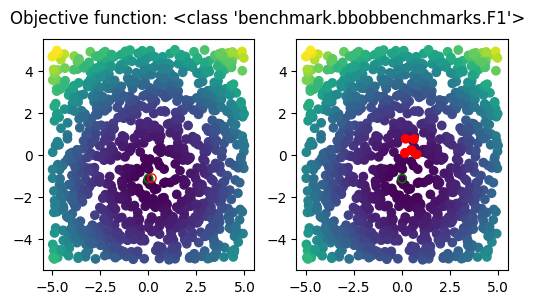

{'err': -0.029993009917959057, 'normalized': -0.00048074381144023776, 'min': 79.5363656985952, 'max': 141.92512495917603, 'found_value': 79.50637268867725, 'found_x': [0.20205841491493612, -1.0025340600770878]}
{'err': 1.5010113343229534, 'normalized': 0.02405900280936248, 'min': 79.5363656985952, 'max': 141.92512495917603, 'found_value': 81.03737703291816, 'found_x': [0.16911083656253545, 0.08833981417401027]}


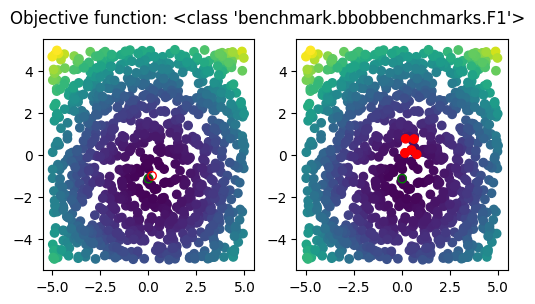

{'err': 24.03833424281453, 'normalized': 0.04865476151759887, 'min': 72.01081930964789, 'max': 566.0700540696342, 'found_value': 96.04915355246241, 'found_x': [2.224800042363003, 0.6300080310672742]}
{'err': 23.221989935994074, 'normalized': 0.04700244080504902, 'min': 72.01081930964789, 'max': 566.0700540696342, 'found_value': 95.23280924564196, 'found_x': [0.4985070123025904, 0.22479664553084766]}


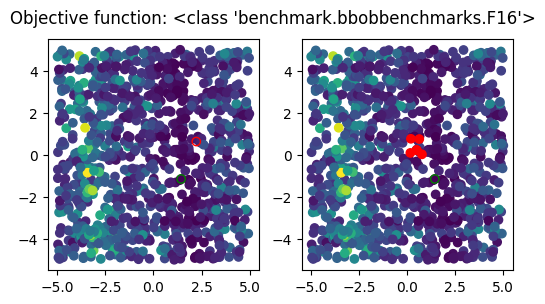

{'err': 19.556255419120433, 'normalized': 0.039582815264288806, 'min': 72.01081930964789, 'max': 566.0700540696342, 'found_value': 91.56707472876832, 'found_x': [0.7633261370825752, 5.0]}
{'err': 23.221989935994074, 'normalized': 0.04700244080504902, 'min': 72.01081930964789, 'max': 566.0700540696342, 'found_value': 95.23280924564196, 'found_x': [0.4985070123025904, 0.22479664553084766]}


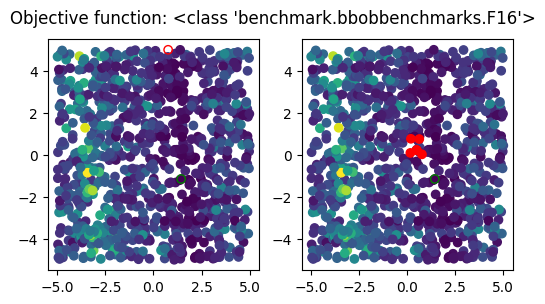

[]

In [118]:
experiment(obj_functions, initial_points, 1000)